In [3]:
import sys
import json
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as scsp
import seaborn as sns
from collections import Counter
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import spacy

from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary

from ast import literal_eval

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer

from sentence_transformers import SentenceTransformer

from dictances import bhattacharyya
from termcolor import colored


/Server/python/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load the databases
df_calls_horizon = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/dataset/horizon_topics.parquet')
df_calls_eic = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/dataset/eic_topics.parquet')
df_publications = pd.read_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/dataset/publications_topics.parquet')

In [5]:
# prepare all the databases for create a common one
df_publications['id'] = df_publications['actID']
df_publications['class'] = 'pub'

df_calls_horizon['raw_text'] = df_calls_horizon['Expected Outcome_raw_text'] + df_calls_horizon['Scope_raw_text']
df_calls_horizon['lemmas'] = df_calls_horizon['Expected Outcome_lemmas'] + df_calls_horizon['Scope_lemmas']
df_calls_horizon['id'] = df_calls_horizon['Call']
df_calls_horizon['class'] = 'call'

df_calls_eic['raw_text'] = df_calls_eic['Background and Scope_raw_text'] + df_calls_eic['Overall Goal & Specific Objectives_raw_text'] + df_calls_eic['Expected Outcomes & Impacts_raw_text']
df_calls_eic['lemmas'] = df_calls_eic['Background and Scope_lemmas'] + df_calls_eic['Overall Goal & Specific Objectives_lemmas'] + df_calls_eic['Expected Outcomes & Impacts_lemmas']
df_calls_eic['class'] = 'call'


In [6]:
# create a common database
df = pd.concat([df_publications[['id', 'class', 'raw_text', 'lemmas', 'tpc_decomposition']], 
                df_calls_horizon[['id', 'class', 'raw_text', 'lemmas', 'tpc_decomposition']], 
                df_calls_eic[['id', 'class', 'raw_text', 'lemmas', 'tpc_decomposition']]])

In [7]:
df.head()

,id,class,raw_text,lemmas,tpc_decomposition
0,act202691,pub,Frequency Domain Model for Calculation of Volt...,frequency_domain model calculation voltage dis...,"[0.00047917815982619706, 0.0003593950747823815..."
1,act318058,pub,Statistical Alignment with a Sequence Evolutio...,statistical_alignment sequence evolution model...,"[0.00038990208834264247, 0.0002924358869956363..."
2,act319397,pub,Multiple Goals and Ownership Structure: Effect...,multiple goals ownership_structure effect perf...,"[0.0008839962786479515, 0.0006630183412100044,..."
3,act319449,pub,Two Steps Reinforcement Learning When applying...,steps reinforcement_learning reinforcement_lea...,"[0.0007298489733344164, 0.0664225982910474, 0...."
4,act319464,pub,Suicidal Altruism Under Random Assortment Ques...,suicidal altruism random assortment questions ...,"[0.0005706399563681183, 0.00042799360861338375..."


# 1. Calculate embeddings

## 1.1. Using word2vec

In [8]:
def get_embeddings(text, model):
    '''
    Function for obtaining the embeddings of a text
    
    text -> Text which we want to obtain embeddings
    model -> word2vec model for obtaining embeddings
    '''
    
    tokens = word_tokenize(text)
    embeddings = [model.wv[token] for token in tokens if token in model.wv]
    if embeddings:
        return sum(embeddings) / len(embeddings)
    else:
        return [0] * model.vector_size

In [9]:
# prepare stopwords
path = '/export/usuarios_ml4ds/mbalairon/topicmodeler/wordlists/horizon_stopwords.json'
with open(path, 'r') as file:
    data = json.load(file)

stopwords_customized = data.get('wordlist', []) 

# Prepare list of stopwords
stop_words = stopwords.words('english') + stopwords_customized +  [',', '.', ')', '(', 'The', ':', 'In', 'This', ';', 'results', 'We', 'different', 
                                                                   'model', 'de', 'also', 'new', 'using', 'based', 'EIC', 'system', 'paper', 'use', 
                                                                   'A', 'used', 'European', 'two', 'systems', 'proposed', 'research', 'including',
                                                                   'one', 'well', 'show', "'s", '%', 'may', 'support', 'models', 'development', 'EU',
                                                                   'la', 'conditions', 'provide', 'number', 'solutions', 'power', '’', 'applications',
                                                                   'It', 'services' + 'present', 'first', 'activities', 'expected', 'relevant', 'obtained',
                                                                   'must', "'", 'properties', 'particular', '=', 'following', 'main', 'en', 'However', 
                                                                   'Spanish', 'problem', '&', 'within', 'methods', 'effects', 'developed', 'Europe', 
                                                                   'related', 'learning', 'terms', "''", 'due', 'techniques', '1', 'three', 'projects',
                                                                   'Spain', 'To', 'studies', 'solution', 'value', 'networks', 'experimental', 
                                                                   'countries', 'possible', 'several', 'increase', '2', 'among','present','provided', 
                                                                   'These','presented', 'compared', 'higher','processes', 'could', 'considered', 
                                                                   'Our', 'need','distribution', 'communication', 'efficiency', 'real', 'associated', 
                                                                   'years', 'novel', 'project', 'For', 'phase', 'contribute', 'problems', 'changes', 
                                                                   'significant', 'applied', 'way', 'future', 'better', 'rate', 'found', 'existing', 
                                                                   '-', 'size', 'approaches', 'cases', '”']

In [10]:
# Tokenize all the textual columns of our databases and clean it 
sentences = [word_tokenize(text) for text in df['raw_text']]

sentences_clean = []
for sentence in sentences: 
    sentence_clean = []
    for word in sentence:
        if word not in stop_words:
            sentence_clean.append(word)
        
    sentences_clean.append(sentence_clean)

In [11]:
# train a word2vec model 
model_w2v = Word2Vec(
            sentences_clean,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=10, # Ignores all words with total frequency lower than 2.
            sg=1, # 1 for skip-gram model
            seed=42)
print(model_w2v)


Word2Vec<vocab=17950, vector_size=200, alpha=0.025>


In [12]:
# obtain embeddings
df['embeddings'] = df['raw_text'].apply(lambda x: get_embeddings(x, model_w2v))

## 1.2. Using BERT

In [13]:
# load a pretrained BERT model 
model_bert = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

/home/mbalairon/.local/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [14]:
# obtain embeddings
df['embeddings_BERT'] = df['raw_text'].apply(lambda x: model_bert.encode(x))

# 2. Calculate the TF-IDF decomposition

In [15]:
# create the corpus and the dictionary 

def get_dict(df, col, stopwords=stop_words):
    corpus = []
    for i in df.index:
        doc = df[col][i]
        # Check if doc is a non-null string before splitting
        if isinstance(doc, str):
            corpus.append(doc.split())

    phrase_model = Phrases(corpus, min_count=2, threshold=20)
    corpus = [el for el in phrase_model[corpus]]

    D = Dictionary(corpus)
    D.filter_extremes(no_below=2, no_above=.5)
    
    stopword_ids = [D.token2id[word] for word in stopwords if word in D.token2id]
    D.filter_tokens(bad_ids=stopword_ids)

    return D


def get_tfidf_decomposition(df, col, stopwords=stop_words):
    '''
    claculate the tf-idf decomposition of a given dataset
    
    df -> Dataset
    col -> Column containing the lemmas
    '''
    D = get_dict(df, col)
    vectorizer_tfidf = TfidfVectorizer(vocabulary=D.token2id)
    tf_idf = vectorizer_tfidf.fit_transform(df[col])
    return tf_idf.toarray().tolist()



In [16]:
df['tf-idf'] = get_tfidf_decomposition(df, 'lemmas')

In [17]:
df.head()

,id,class,raw_text,lemmas,tpc_decomposition,embeddings,embeddings_BERT,tf-idf
0,act202691,pub,Frequency Domain Model for Calculation of Volt...,frequency_domain model calculation voltage dis...,"[0.00047917815982619706, 0.0003593950747823815...","[-0.038340226, 0.07109314, -0.0051208185, -0.0...","[-0.029691374, -0.41700935, 0.66564405, 0.7140...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,act318058,pub,Statistical Alignment with a Sequence Evolutio...,statistical_alignment sequence evolution model...,"[0.00038990208834264247, 0.0002924358869956363...","[-0.06862614, 0.09916243, -0.05999394, -0.0243...","[-0.0731751, -0.30709776, 0.28145033, 0.752468...","[0.0, 0.0, 0.48659707089856086, 0.041532539984..."
2,act319397,pub,Multiple Goals and Ownership Structure: Effect...,multiple goals ownership_structure effect perf...,"[0.0008839962786479515, 0.0006630183412100044,...","[-0.011145301, 0.07509699, -0.0050715893, 0.09...","[0.44102132, -0.25127748, 0.3081478, 0.2345308...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,act319449,pub,Two Steps Reinforcement Learning When applying...,steps reinforcement_learning reinforcement_lea...,"[0.0007298489733344164, 0.0664225982910474, 0....","[-0.046913266, 0.09865982, 0.03833785, -0.0086...","[-0.38342857, -0.005360201, 0.49466625, 0.0583...","[0.0, 0.0, 0.0, 0.13491643110269944, 0.0, 0.0,..."
4,act319464,pub,Suicidal Altruism Under Random Assortment Ques...,suicidal altruism random assortment questions ...,"[0.0005706399563681183, 0.00042799360861338375...","[-0.011829279, 0.068405196, -0.039312523, 0.03...","[-0.05451139, -0.061830524, 0.18337458, -0.105...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 3. Similarity Measures - Similarity Cosine

In [18]:
# obtain the datasets for publications and researchers separately
df_group = df.groupby('class')

# Acceder a un subconjunto específico
df_pub = df_group.get_group('pub')
df_call = df_group.get_group('call')


## 3.1. Using word2vec embeddings

In [19]:
embeddings_publications = np.vstack(df_pub['embeddings'].to_list())
embeddings_calls = np.vstack(df_call['embeddings'].to_list()) 

# Normalize embeddings for cosine distance
embeddings_publications_normalized = normalize(embeddings_publications)
embeddings_calls_normalized = normalize(embeddings_calls)

# compute similarity matrix
cosine_sim_matrix = cosine_similarity(embeddings_publications_normalized, embeddings_calls_normalized)


In [32]:
header_calls = df_call['id'].to_list()
header_pubs = df_pub['id'].to_list()
cosine_sim_matrix = pd.DataFrame(cosine_sim_matrix, columns=header_calls, index=header_pubs)
    

In [33]:
cosine_sim_matrix.shape

(15710, 667)

In [34]:
cosine_sim_matrix.head()

,HORIZON-HLTH-2023-STAYHLTH-01-01,HORIZON-HLTH-2024-STAYHLTH-01-02-two-stage,HORIZON-HLTH-2024-STAYHLTH-01-05-two-stage,HORIZON-HLTH-2023-ENVHLTH-02-01,HORIZON-HLTH-2023-ENVHLTH-02-02,HORIZON-HLTH-2023-ENVHLTH-02-03,HORIZON-HLTH-2023-ENVHLTH-02-04,HORIZON-HLTH-2024-ENVHLTH-02-06-two-stage,HORIZON-HLTH-2023-DISEASE-03-01,HORIZON-HLTH-2023-DISEASE-03-03,...,HORIZON-CL6-2024-GOVERNANCE-01-12,HORIZON-CL6-2024-GOVERNANCE-01-13,0,1,2,3,4,5,6,7
act202691,0.686743,0.669472,0.752438,0.706488,0.706732,0.779312,0.716561,0.748108,0.701470,0.720986,...,0.688896,0.691310,0.838196,0.812509,0.785272,0.808257,0.739421,0.854551,0.834651,0.737514
act318058,0.665041,0.662493,0.747834,0.688624,0.716243,0.772823,0.709420,0.732763,0.695456,0.710098,...,0.691316,0.689958,0.752479,0.762551,0.768906,0.727201,0.744735,0.818967,0.784388,0.743353
act319397,0.867819,0.874371,0.893651,0.877024,0.916160,0.900497,0.910822,0.892505,0.867881,0.889147,...,0.913770,0.912755,0.816951,0.887821,0.900083,0.822972,0.927912,0.895070,0.880635,0.927364
act319449,0.709299,0.699664,0.772235,0.708333,0.731625,0.787291,0.758793,0.751897,0.726395,0.729225,...,0.734547,0.725796,0.763483,0.799153,0.762608,0.759194,0.796197,0.854414,0.804203,0.794970
act319464,0.831702,0.850505,0.894476,0.840758,0.881192,0.895108,0.849486,0.875805,0.864290,0.868121,...,0.832684,0.834961,0.766555,0.834736,0.917732,0.781688,0.875188,0.884666,0.857436,0.874383


In [55]:
cosine_sim_matrix.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/cosine_sim_matrix_we_doc2vec.parquet', index=True)

## 3.2. Using BERT embeddings 

In [36]:
embeddings_publications_BERT = np.vstack(df_pub['embeddings_BERT'].to_list())
embeddings_calls_BERT = np.vstack(df_call['embeddings_BERT'].to_list()) # group together all the calls

# Normalize embeddings for cosine distance
embeddings_publications_normalized_BERT = normalize(embeddings_publications_BERT)
embeddings_calls_normalized_BERT = normalize(embeddings_calls_BERT)

# compute similarity matrix
cosine_sim_matrix_BERT = cosine_similarity(embeddings_publications_normalized_BERT, embeddings_calls_normalized_BERT)
cosine_sim_matrix_BERT = pd.DataFrame(cosine_sim_matrix_BERT, columns=header_calls, index=header_pubs)


In [37]:
cosine_sim_matrix_BERT.shape

(15710, 667)

In [39]:
cosine_sim_matrix_BERT.head()

,HORIZON-HLTH-2023-STAYHLTH-01-01,HORIZON-HLTH-2024-STAYHLTH-01-02-two-stage,HORIZON-HLTH-2024-STAYHLTH-01-05-two-stage,HORIZON-HLTH-2023-ENVHLTH-02-01,HORIZON-HLTH-2023-ENVHLTH-02-02,HORIZON-HLTH-2023-ENVHLTH-02-03,HORIZON-HLTH-2023-ENVHLTH-02-04,HORIZON-HLTH-2024-ENVHLTH-02-06-two-stage,HORIZON-HLTH-2023-DISEASE-03-01,HORIZON-HLTH-2023-DISEASE-03-03,...,HORIZON-CL6-2024-GOVERNANCE-01-12,HORIZON-CL6-2024-GOVERNANCE-01-13,0,1,2,3,4,5,6,7
act202691,0.403016,0.393341,0.390902,0.415864,0.455316,0.378571,0.366021,0.421281,0.331162,0.348692,...,0.442692,0.422809,0.328868,0.380609,0.260726,0.455550,0.308224,0.426523,0.429589,0.649350
act318058,0.351954,0.372911,0.395473,0.423361,0.450449,0.395326,0.414395,0.405702,0.336042,0.351958,...,0.427861,0.379768,0.108954,0.271275,0.298966,0.263194,0.321159,0.415028,0.184259,0.465097
act319397,0.387998,0.399268,0.461681,0.362368,0.418652,0.442722,0.409217,0.459147,0.361308,0.378260,...,0.341568,0.327468,0.227574,0.263084,0.372808,0.252552,0.342599,0.333590,0.240948,0.328558
act319449,0.449601,0.493200,0.494749,0.594640,0.671116,0.546567,0.576483,0.596521,0.443115,0.421615,...,0.558269,0.516603,0.292397,0.420391,0.303609,0.282325,0.310493,0.451827,0.285409,0.435031
act319464,0.419428,0.375795,0.449695,0.356549,0.386343,0.333015,0.300946,0.353806,0.411872,0.433996,...,0.325973,0.252521,0.224136,0.351795,0.319392,0.334209,0.305518,0.206455,0.336828,0.354187


In [52]:
cosine_sim_matrix_BERT.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/cosine_sim_matrix_we_BERT.parquet', index=True)

/Server/python/anaconda3/lib/python3.10/site-packages/pandas/io/parquet.py:159: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


## 3.3.  Using TF-IDF

In [42]:
tfidf_publications = np.vstack(df_pub['tf-idf'].to_list())
tfidf_calls = np.vstack(df_call['tf-idf'].to_list()) # group together all the calls

# Normalize tf-idf for cosine distance
tfidf_publications_normalized = normalize(tfidf_publications)
tfidf_calls_normalized = normalize(tfidf_calls)

# compute similarity matrix
cosine_sim_matrix_tfidf = cosine_similarity(tfidf_publications_normalized, tfidf_calls_normalized)
cosine_sim_matrix_tfidf = pd.DataFrame(cosine_sim_matrix_tfidf, columns=header_calls, index=header_pubs)


In [43]:
cosine_sim_matrix_tfidf.shape

(15710, 667)

In [44]:
cosine_sim_matrix_tfidf.head()

,HORIZON-HLTH-2023-STAYHLTH-01-01,HORIZON-HLTH-2024-STAYHLTH-01-02-two-stage,HORIZON-HLTH-2024-STAYHLTH-01-05-two-stage,HORIZON-HLTH-2023-ENVHLTH-02-01,HORIZON-HLTH-2023-ENVHLTH-02-02,HORIZON-HLTH-2023-ENVHLTH-02-03,HORIZON-HLTH-2023-ENVHLTH-02-04,HORIZON-HLTH-2024-ENVHLTH-02-06-two-stage,HORIZON-HLTH-2023-DISEASE-03-01,HORIZON-HLTH-2023-DISEASE-03-03,...,HORIZON-CL6-2024-GOVERNANCE-01-12,HORIZON-CL6-2024-GOVERNANCE-01-13,0,1,2,3,4,5,6,7
act202691,0.004742,0.002361,0.004979,0.001612,0.015736,0.004823,0.000000,0.000000,0.003711,0.003882,...,0.000000,0.000000,0.000000,0.018475,0.001567,0.007154,0.002454,0.013173,0.010661,0.002344
act318058,0.002523,0.000000,0.009785,0.004313,0.011696,0.006448,0.007460,0.017029,0.000000,0.001781,...,0.002525,0.000000,0.006894,0.018004,0.001498,0.001626,0.002955,0.007163,0.018299,0.002848
act319397,0.007093,0.009305,0.016773,0.004598,0.016484,0.023862,0.014939,0.004897,0.014081,0.024854,...,0.018413,0.025874,0.009593,0.016604,0.006208,0.004570,0.008055,0.004596,0.008657,0.007983
act319449,0.012294,0.000000,0.029361,0.011873,0.007954,0.007425,0.000000,0.008477,0.002857,0.010907,...,0.000000,0.012036,0.009291,0.042477,0.009852,0.007921,0.010849,0.000000,0.044213,0.009569
act319464,0.007713,0.006003,0.007180,0.003316,0.004622,0.005957,0.003409,0.008121,0.036970,0.005116,...,0.000000,0.000000,0.007243,0.014636,0.003088,0.009803,0.003686,0.003932,0.010494,0.003618


In [53]:
cosine_sim_matrix_tfidf.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/osine_sim_matrix_tfidf.parquet', index=True)

# 4. Similarity Measures - Bhattacharayya Between topics

In [56]:
def bhattacharyya_similarity(p, q):
    '''
    Function for computing the bhattacharyya similarity between two distributions
    
    p, q -> Distributions
    '''
    
    p = np.array(p)
    q = np.array(q)

    return (np.sum(np.sqrt(p * q)))




In [57]:
matrix_pub = np.array(df_pub['tpc_decomposition'])
matrix_call = np.array(df_call['tpc_decomposition'])

similarity_matrix = np.zeros((len(matrix_pub), len(matrix_call)))

# Llena la matriz de similitud
for i in range(len(matrix_pub)):
    pub_dist = matrix_pub[i]
    if pub_dist is None:
            pub_dist = [0] * 44
            
    for j in range(len(matrix_call)):
        call_dist = matrix_call[j]
        if call_dist is None:
                call_dist = [0] * 44
        
        similarity_matrix[i, j] = bhattacharyya_similarity(pub_dist, call_dist)



In [58]:
similarity_matrix = pd.DataFrame(similarity_matrix, columns=header_calls, index=header_pubs)


In [59]:
similarity_matrix.shape

(15710, 667)

In [60]:
similarity_matrix.head()

,HORIZON-HLTH-2023-STAYHLTH-01-01,HORIZON-HLTH-2024-STAYHLTH-01-02-two-stage,HORIZON-HLTH-2024-STAYHLTH-01-05-two-stage,HORIZON-HLTH-2023-ENVHLTH-02-01,HORIZON-HLTH-2023-ENVHLTH-02-02,HORIZON-HLTH-2023-ENVHLTH-02-03,HORIZON-HLTH-2023-ENVHLTH-02-04,HORIZON-HLTH-2024-ENVHLTH-02-06-two-stage,HORIZON-HLTH-2023-DISEASE-03-01,HORIZON-HLTH-2023-DISEASE-03-03,...,HORIZON-CL6-2024-GOVERNANCE-01-12,HORIZON-CL6-2024-GOVERNANCE-01-13,0,1,2,3,4,5,6,7
act202691,0.055196,0.061919,0.073926,0.046725,0.079980,0.098649,0.077909,0.074015,0.052440,0.055333,...,0.094131,0.085888,0.333309,0.333309,0.333309,0.333309,0.333309,0.333309,0.333309,0.333309
act318058,0.197633,0.157352,0.308003,0.188605,0.230021,0.318962,0.120385,0.285311,0.308027,0.227881,...,0.078391,0.063963,0.428797,0.428797,0.428797,0.428797,0.428797,0.428797,0.428797,0.428797
act319397,0.071511,0.079998,0.076274,0.065905,0.093928,0.101187,0.170740,0.093233,0.069610,0.072358,...,0.142209,0.073799,0.456283,0.456283,0.456283,0.456283,0.456283,0.456283,0.456283,0.456283
act319449,0.107018,0.114486,0.176843,0.067002,0.098906,0.144221,0.140218,0.086814,0.073435,0.083705,...,0.093470,0.082363,0.543350,0.543350,0.543350,0.543350,0.543350,0.543350,0.543350,0.543350
act319464,0.337962,0.328235,0.374831,0.261941,0.354518,0.420960,0.189025,0.424107,0.437279,0.385278,...,0.105507,0.070961,0.464743,0.464743,0.464743,0.464743,0.464743,0.464743,0.464743,0.464743


In [61]:
similarity_matrix.to_parquet('/export/usuarios_ml4ds/mbalairon/github/recommendation_system/bhattacharyya_sim_matrix.parquet', index=True)

/Server/python/anaconda3/lib/python3.10/site-packages/pandas/io/parquet.py:159: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


# 5. Plots

In [ ]:
cosine_sim_matrix_tfidf

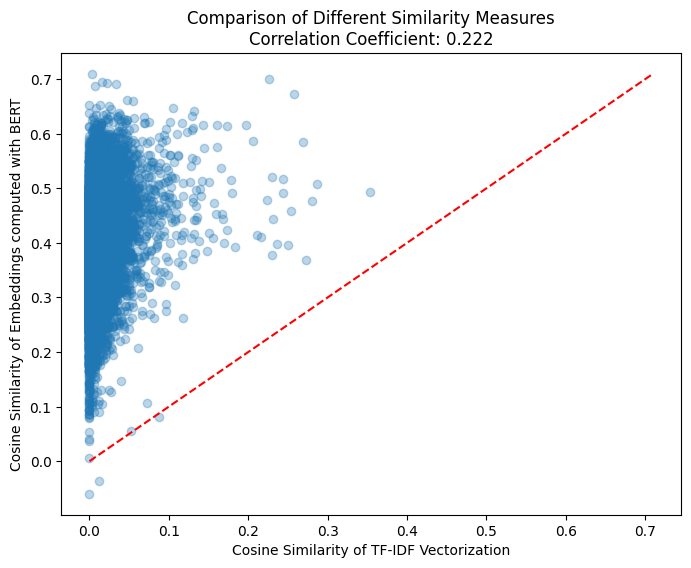

In [95]:
x_values = []
y_values = []

# Iterar sobre los índices de los DataFrames y obtener los valores correspondientes de cada celda
for i in range(len(similarity_matrix)):
    x = cosine_sim_matrix_tfidf.iloc[i].values[0]  # Valor de la celda en la posición (i, 0) del DataFrame 1
    y = cosine_sim_matrix_BERT.iloc[i].values[0]  # Valor de la celda en la posición (i, 0) del DataFrame 2
    x_values.append(x)
    y_values.append(y)

correlation_coefficient = np.corrcoef(x_values, y_values)[0, 1]

# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(x_values, y_values, alpha=0.3)

max_value = max(max(x_values), max(y_values))
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--')


# Añadir etiquetas
plt.xlabel('Cosine Similarity of TF-IDF Vectorization')
plt.ylabel('Cosine Similarity of Embeddings computed with BERT')
plt.title('Comparison of Different Similarity Measures\nCorrelation Coefficient: {}'.format(round(correlation_coefficient, 4)))

# Mostrar el gráfico
plt.show()